## **Importando as dependências, OS e iniciando SparkSession**

In [1]:
#instalação da biblioteca pyspark
!pip install pyspark==3.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 45 kB/s 
     |████████████████████████████████| 199 kB 51.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=afa6e30aee409a88fd97ebe00269b5d6c0cd2821e373da8cc59d1d7abf71a778
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
#importando a função SparkSession da biblioteca pyspark.sql
from pyspark.sql import SparkSession

In [3]:
#criando a sessão spark
spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Iniciando com Spark") \
    .config('spark.ui.port', '4050') \
    .getOrCreate()

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "https://archive.apache.org/dist/spark/spark-3.3.1/spark-3.3.1-bin-hadoop2.tgz"


In [5]:
spark

In [6]:
!wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [7]:
get_ipython().system_raw('./ngrok authtoken 2IAzSgOhNxfkxrV1MQEmNqrHBRS_2PDkj8UN4X5gPJWnHXhrq')
get_ipython().system_raw('./ngrok http 4050 &')

In [8]:
!curl -s http://localhost:4040/api/tunnels

{"tunnels":[],"uri":"/api/tunnels"}


In [9]:
# carregando o arquivo

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Carregando e visualizando os dados**

In [10]:
#importando os dados
dados = spark.read.parquet('/content/drive/MyDrive/Imoveis/Dados')

In [11]:
dados.show()

+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|              bairro|condominio|  iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|00002dd9-cc74-480...|    2|       35|        1|      1|   0.0| 0.0|        Santo Cristo|     100.0| 100.0

In [12]:
#verificando quantos bairros existem na base de dados
dados.select('bairro').distinct().count()

150

In [13]:
#verificando quantos imóveis existem em cada bairro
dados.groupBy('bairro').count().sort('count', ascending=False).show()

+--------------------+-----+
|              bairro|count|
+--------------------+-----+
|     Barra da Tijuca|12788|
|Recreio dos Bande...| 7792|
|          Copacabana| 6784|
|         Jacarepaguá| 4437|
|              Tijuca| 3638|
|            Botafogo| 3498|
|Freguesia (Jacare...| 2267|
|             Ipanema| 2113|
|              Leblon| 1893|
|            Flamengo| 1377|
|             Taquara| 1247|
|               Lagoa| 1218|
|           Pechincha| 1199|
|         Laranjeiras|  950|
|         Vila Isabel|  913|
|              Centro|  708|
|                Anil|  672|
|        Campo Grande|  639|
|            Cachambi|  613|
|               Gávea|  597|
+--------------------+-----+
only showing top 20 rows



In [14]:
#iniciando uma lista que irá incorporar as colunas que serão utiizadas como features
X = dados.columns
X.remove('bairro')
X.remove('id')

## **Vetorizando e padronizando, escalando os dados e PCA**

In [15]:
#PCA é sensível a escalas discrepantes, por isso o VectorAssembler é utilizado para padronização

from pyspark.ml.feature import VectorAssembler

In [16]:
#apenas para conferência, gerando um modelo sem redução das dimensões
dados_vector = VectorAssembler(inputCols=X, outputCol='features').transform(dados)

In [17]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol='features', outputCol='features_scaled')
model_scaler = scaler.fit(dados_vector)
dados_scaler = model_scaler.transform(dados_vector)

In [18]:
from pyspark.ml.feature import PCA
pca = PCA(k=len(X), inputCol='features_scaled', outputCol='pca_features')
model_pca = pca.fit(dados_scaler)

In [19]:
#verificando que o modelo não reduz dimensões
sum(model_pca.explainedVariance) * 100

100.0

## **Redução de dimensionalidade**

Os dados precisam estar com as dimensões reduzidas para criar o modelo de recomendação, tarefa que será executada através da técnica PCA. Será gerado um conjunto novo de dados, com uma combinação das colunas originais.

In [20]:
lista_valores = [sum(model_pca.explainedVariance[0:i+1]) for i in range(len(X))]
lista_valores

[0.26545749360997034,
 0.4375247949776184,
 0.5287992767783259,
 0.5831729986362391,
 0.6354028103524717,
 0.682023156221161,
 0.7262890569978575,
 0.7678911881686676,
 0.8025730095613413,
 0.8297996535128337,
 0.854194399626073,
 0.8742987112956476,
 0.8935090265260494,
 0.9111213166740558,
 0.9266283824348652,
 0.9405231608927351,
 0.9525305733295567,
 0.9638657310284791,
 0.9739753651565556,
 0.983205487506614,
 0.9921039340092773,
 0.9999999999999953,
 1.0]

In [21]:
#determinando a redução das dimensões, ajustando 70% como a taxa mínima de explicação para os componentes.
# Ou seja: quero obter uma redução de dimensões que não gere muita perda de informação
import numpy as np
k = sum(np.array(lista_valores) <= 0.7)
k

6

## **Pipeline**

In [22]:
#criando o pipeline, com o valor de k obtido da etapa de determinação das dimensões
from pyspark.ml import Pipeline
pca_pipeline = Pipeline(stages=[VectorAssembler(inputCols=X, outputCol='features'),
                                StandardScaler(inputCol='features', outputCol='scaled_features'),
                                PCA(k=k, inputCol='scaled_features', outputCol='pca_features')])

In [23]:
#ajustando o pipeline
pca_pipeline_model = pca_pipeline.fit(dados)

In [24]:
dados_pca = pca_pipeline_model.transform(dados)

In [25]:
dados_pca.select('pca_features').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                               |
+---------------------------------------------------------------------------------------------------------------------------+
|[-6.165125049533812,1.3380985269405696,-1.7052299823820158,-0.5338289630560162,0.08903815478581815,-0.3134396180129953]    |
|[-3.2529111812184865,-1.1179591836228857,-0.2923895841501507,3.195538820020636,0.1528630698219846,1.302893049066197]       |
|[-1.0611769329629537,-1.6685040058694294,-2.30759482783911,0.10553124125788461,-0.06914386452866851,0.7187181899556143]    |
|[-1.995811900783872,-1.7655796610847843,1.3571962498672347,-0.16336519381168974,-0.021305227846957334,0.12808044918214828] |
|[-0.4181406070145923,-2.131040791141693,-0.1026409926497008,2.809916415039177,-0.042956284698168964,-0.09449068767336

## **Criando os clusters - kMeans**

In [26]:
#importando a função KMeans
from pyspark.ml.clustering import KMeans

In [27]:
#calculando a quantidade adequada de clusters para esse dataset, entre 2 e 50

costs = {}
for k in range(2, 50):
    k_means = KMeans(featuresCol='pca_features', k=k, seed=101)
    model = k_means.fit(dados_pca)
    costs[k] = model.summary.trainingCost

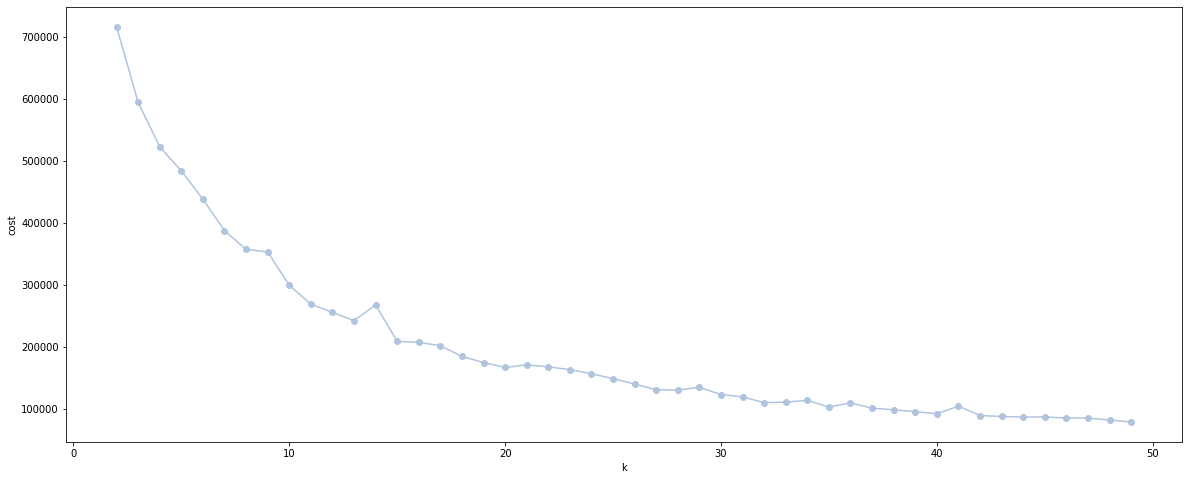

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize =(20, 8))

ax.plot(list(costs.keys()), list(costs.values()),**{'color': 'lightsteelblue', 'marker': 'o'})
ax.set_xlabel('k')
ax.set_ylabel('cost')
plt.show()

Analisando o gráfico, 13 parece ser um bom candidato para quantidade de clusters.

In [29]:
#constante de aleatoriedade
SEED = 1224

In [30]:
#criando o kMean - ssetk() é usada para determinar quantos clusters serão empregados
kmeans = KMeans(featuresCol='pca_features', predictionCol='cluster_pca').setK(13).setSeed(SEED)

In [31]:
model_kmeans = kmeans.fit(dados_pca)

In [32]:
prections_kmeans = model_kmeans.transform(dados_pca)

In [33]:
prections_kmeans.select('pca_features', 'cluster_pca').show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------+-----------+
|pca_features                                                                                                               |cluster_pca|
+---------------------------------------------------------------------------------------------------------------------------+-----------+
|[-6.165125049533812,1.3380985269405696,-1.7052299823820158,-0.5338289630560162,0.08903815478581815,-0.3134396180129953]    |7          |
|[-3.2529111812184865,-1.1179591836228857,-0.2923895841501507,3.195538820020636,0.1528630698219846,1.302893049066197]       |5          |
|[-1.0611769329629537,-1.6685040058694294,-2.30759482783911,0.10553124125788461,-0.06914386452866851,0.7187181899556143]    |10         |
|[-1.995811900783872,-1.7655796610847843,1.3571962498672347,-0.16336519381168974,-0.021305227846957334,0.12808044918214828] |11         |
|[-0.4181406070145923,-2.131040791

# **Avaliando as informações de cada cluster**

In [34]:
#aqui podemos notar que existe uma grande variação entre os clusters. Um com 27 imóveis e outros com mais de 11 mil,  por exemplo.
prections_kmeans.groupBy('cluster_pca').count().orderBy('cluster_pca').show(13)

+-----------+-----+
|cluster_pca|count|
+-----------+-----+
|          0| 3096|
|          1| 3392|
|          2| 5726|
|          3|   27|
|          4| 3295|
|          5| 4549|
|          6| 6789|
|          7|11420|
|          8| 5859|
|          9| 1923|
|         10| 8523|
|         11| 7201|
|         12| 4751|
+-----------+-----+



In [35]:
cluster_means = prections_kmeans\
                              .groupBy('cluster_pca')\
                              .mean()
     

In [36]:
from pyspark.sql import functions as f

In [37]:
cluster_means\
          .orderBy('avg(area_util)')\
          .withColumn('Area Útil', f.round(cluster_means['avg(area_util)'],2))\
          .select('cluster_pca','Area Útil')\
          .show()

+-----------+---------+
|cluster_pca|Area Útil|
+-----------+---------+
|          5|    74.69|
|          7|    79.95|
|         11|    83.84|
|          2|    85.34|
|          6|    85.88|
|          8|    92.24|
|         10|    94.58|
|          1|   108.68|
|         12|   184.53|
|          4|    226.6|
|          0|   233.26|
|          3|    260.3|
|          9|   402.03|
+-----------+---------+



Em relação a área útil, os clusters 3 e 9 possuem os maiores valores.
Já os clusters 5 e 7 possuem os menores.

In [38]:
cluster_means\
          .orderBy('avg(valor)')\
          .withColumn('Valor', f.round(cluster_means['avg(valor)'],2))\
          .select('cluster_pca','Valor')\
          .show()

+-----------+----------+
|cluster_pca|     Valor|
+-----------+----------+
|          6| 489387.83|
|          5| 507724.48|
|          7| 642895.11|
|         11| 649895.96|
|          8| 836778.27|
|          2| 989782.96|
|         10|1242163.58|
|          1|1844316.52|
|         12|2033351.65|
|          0|2362911.95|
|          4|3782213.57|
|          3|3954287.41|
|          9|5998344.33|
+-----------+----------+



Comparando os valores de área útil com a média de preços de cada cluster, podemos notar que aqueles com mais área útil também são os mais caros (clusters 3 e 9). 

# **Filtrando imóveis do mesmo cluster**

O método aplicado precisa ser testado. Para isso, foi escolhido um imóvel aleatório e o cluster em que ele estava inserido foi usado para filtrar os dados.

Fazendo somente isso existe um grau de aleatoriedade nos resultados, por isso o próximo passo será calcular a distância euclidiana e ordenador os resultados.

In [39]:
#selecionando um imóvel aleatório pelo id
id = prections_kmeans.select('id').collect()[0][0]
id

'00002dd9-cc74-4809-b5a5-850adf0e7526'

In [40]:
#verificando os dados do imóvel selecionado
prections_kmeans.filter(prections_kmeans.id == id).show(truncate=False)

+------------------------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+-------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------+-----------+
|id                                  |andar|area_util|banheiros|quartos|suites|vaga|bairro      |

In [41]:
#criando uma variável para armazenar o cluster_pca do imóvel
cluster = prections_kmeans.filter(prections_kmeans.id == id).select('cluster_pca').collect()[0][0]
cluster

7

In [42]:
#filtrando os imóveis pelo cluster_pca
imoveis_recomendados = prections_kmeans.filter(prections_kmeans.cluster_pca == cluster)
imoveis_recomendados.show()

+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+--------------------+--------------------+--------------------+-----------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|              bairro|condominio|  iptu|    valor|Zona Central|Zona Norte|Zona Oeste|Zona Sul|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|            features|     scaled_features|        pca_features|cluster_pca|
+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+------+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+----

# **Calculando distância Euclidiana**

In [43]:
#componentes usados no cálculo da distância euclediana
componentes = imoveis_recomendados.filter(imoveis_recomendados.id == id).select('pca_features').collect()[0][0]
componentes

DenseVector([-6.1651, 1.3381, -1.7052, -0.5338, 0.089, -0.3134])

In [44]:
from scipy.spatial.distance import euclidean
from pyspark.sql.types import FloatType
from pyspark.sql import functions as f

In [45]:
#determinando a distância euclidiana entre o imóvel escolhido e os demais do mesmo cluster
def calcula_distance(value):
  return euclidean(componentes, value)

udf_calcula_distance = f.udf(calcula_distance, FloatType())
imoveis_recomendados_dist = imoveis_recomendados.withColumn('Dist', udf_calcula_distance('pca_features'))
recomendados = imoveis_recomendados_dist.select('id', 'bairro', 'Dist').sort('Dist')
recomendados.show(truncate=False)

+------------------------------------+------------+-----------+
|id                                  |bairro      |Dist       |
+------------------------------------+------------+-----------+
|00002dd9-cc74-4809-b5a5-850adf0e7526|Santo Cristo|0.0        |
|5dac977a-6cfb-4283-a247-9478beca6bce|Centro      |0.008500492|
|a1c430e5-fe77-4b0f-a08c-001f57f11f89|Centro      |0.011903712|
|33aeb3e6-f85d-49b0-a758-c5252c5623e6|Centro      |0.019963495|
|a99baaa1-00ef-4906-8903-3f8a38a06385|Centro      |0.028192494|
|9bff3d1a-b865-4652-9b87-e26b3faf5c79|Centro      |0.037412748|
|d4b24d12-383c-4379-9ecb-89906f7dbba9|Centro      |0.037550464|
|d187d98b-2291-4865-8225-58497cc101c9|Santo Cristo|0.040353443|
|b3d1d649-f026-48ac-a0a5-dbb14ada1f61|Centro      |0.04079916 |
|1238503b-dbbc-4664-a48b-e94195624404|Santo Cristo|0.04395238 |
|562af84b-6b6d-4220-b79b-426a79148cb9|Santo Cristo|0.04501169 |
|3fe19ed1-3b37-4ac9-8b2e-a8b8f27e25d6|Santo Cristo|0.04573038 |
|63b14166-0cd2-40fa-878d-51d3fae968e0|Sa

# **Criando uma função recomendadora**

Aqui foi criada a função recomendadora, onde o usuário escolhe o imóvel de referência e quantos outros ele deseja receber como recomendação.

In [46]:
def recomendador(id, numero):
  cluster = prections_kmeans.filter(prections_kmeans.id == id).select('cluster_pca').collect()[0][0]
  imoveis_recomendados = prections_kmeans.filter(prections_kmeans.cluster_pca == cluster)
  componentes = imoveis_recomendados.filter(imoveis_recomendados.id == id).select('pca_features').collect()[0][0]
  udf_calcula_distance = f.udf(calcula_distance, FloatType())
  imoveis_recomendados_dist = imoveis_recomendados.withColumn('Dist', udf_calcula_distance('pca_features'))
  recomendados = spark.createDataFrame(imoveis_recomendados_dist.sort('Dist').take(numero)).select(['id', 'Dist'])
  recomendados.select('id').show(truncate=False)


In [47]:
#utilizando o mesmo id na função recomendadora
recomendador('00002dd9-cc74-4809-b5a5-850adf0e7526', 10)

+------------------------------------+
|id                                  |
+------------------------------------+
|00002dd9-cc74-4809-b5a5-850adf0e7526|
|5dac977a-6cfb-4283-a247-9478beca6bce|
|a1c430e5-fe77-4b0f-a08c-001f57f11f89|
|33aeb3e6-f85d-49b0-a758-c5252c5623e6|
|a99baaa1-00ef-4906-8903-3f8a38a06385|
|9bff3d1a-b865-4652-9b87-e26b3faf5c79|
|d4b24d12-383c-4379-9ecb-89906f7dbba9|
|d187d98b-2291-4865-8225-58497cc101c9|
|b3d1d649-f026-48ac-a0a5-dbb14ada1f61|
|1238503b-dbbc-4664-a48b-e94195624404|
+------------------------------------+



In [48]:
spark.stop()